데이터3 EDA&전처리 내용
1. row 1941개, 중복값 없음, 결측치 없음
2. 독립변수 27개 중 범주형 3개(['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']) -> 변수 갯수에 비해 데이터 수가 적음 
* Outside_Global_Index 컬럼에 대해 원핫 인코딩 적용 
* type of steel 300/400 컬럼을 1개로 통일(1이면 300,0이면 400)
* +PCA 고려해봤으나, 신경망을 사용할 경우 dense layer에 입력값을 조정하면 차원 축소한 것과 같은 효과를 보이므로 여기에서는 PCA하지 않음. 다만, 신경망 모델을 사용하지 않을 시 차원 축소 기법 적용 필요
3. target변수 7개이며, class 비율이 2.8% 부터 34.7% 까지 존재 => 추후 샘플링 기법 적용 필요
4. 이상치가 다수 존재 -> 바이올린 플롯으로 시각화, 맥스값으로 클립
5. skewed data에 대해 로그변환
6. 표준화

* 이 파일로 전처리된 데이터에 샘플링(+차원축소), 모델 학습&하이퍼파라미터 튜닝 작업 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

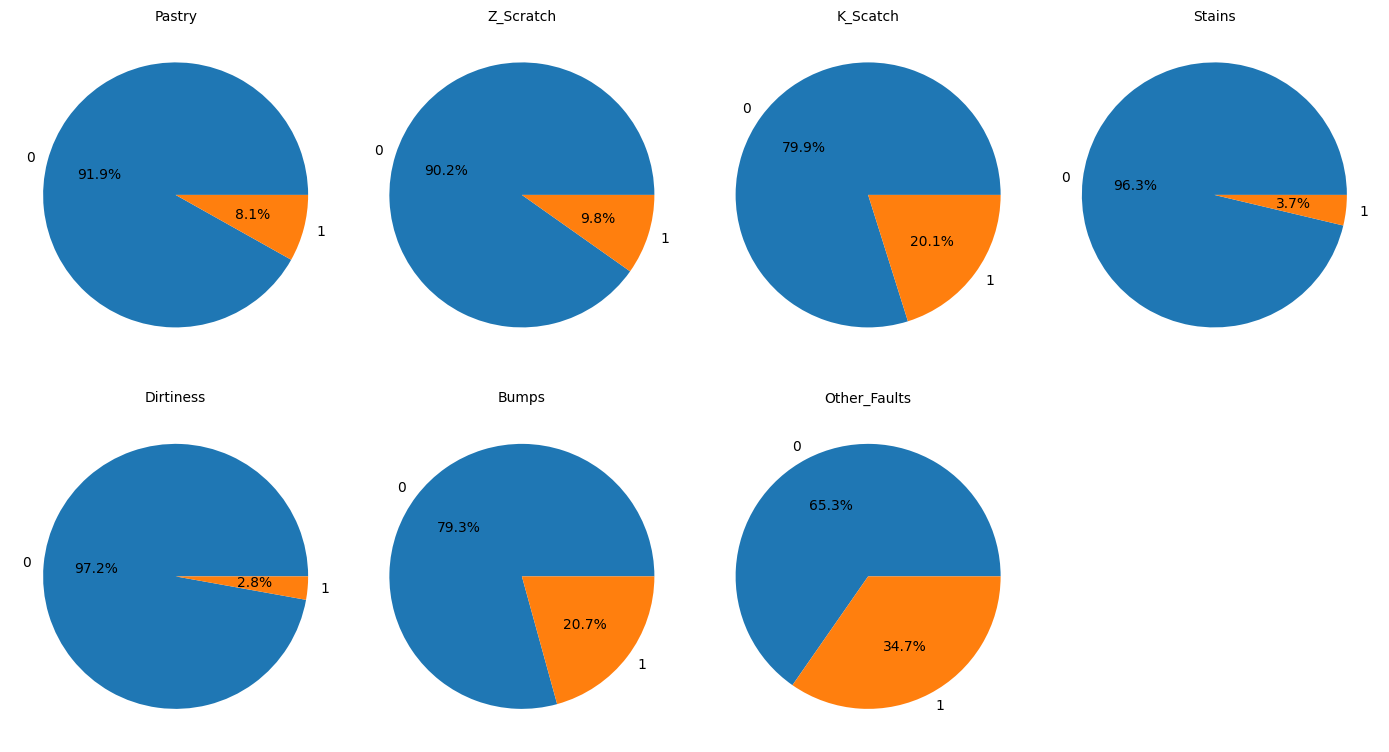

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf

df3 = pd.read_csv('data/mulit_classification_data.csv')
df3.info()
print(f'\n 중복항 존재여부 : {df3.duplicated().any()}\n')

# 하자가 없는 row가 있는지 확인
print(f'하자없는 row : {df3.iloc[:,27:].apply(lambda row: not (row == 1).any(), axis=1).any()}')

print('target class 비율')
fig = plt.figure(figsize=(14,8))
x = 0
for i in df3.iloc[:,27:].columns:
    x += 1
    temp = df3[i].value_counts()
    ax = fig.add_subplot(240+x)
    ax.pie(temp, labels=[0,1], autopct='%1.1f%%')
    ax.set_title(i, fontsize=10)
plt.tight_layout()
plt.show()

In [4]:
df3.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


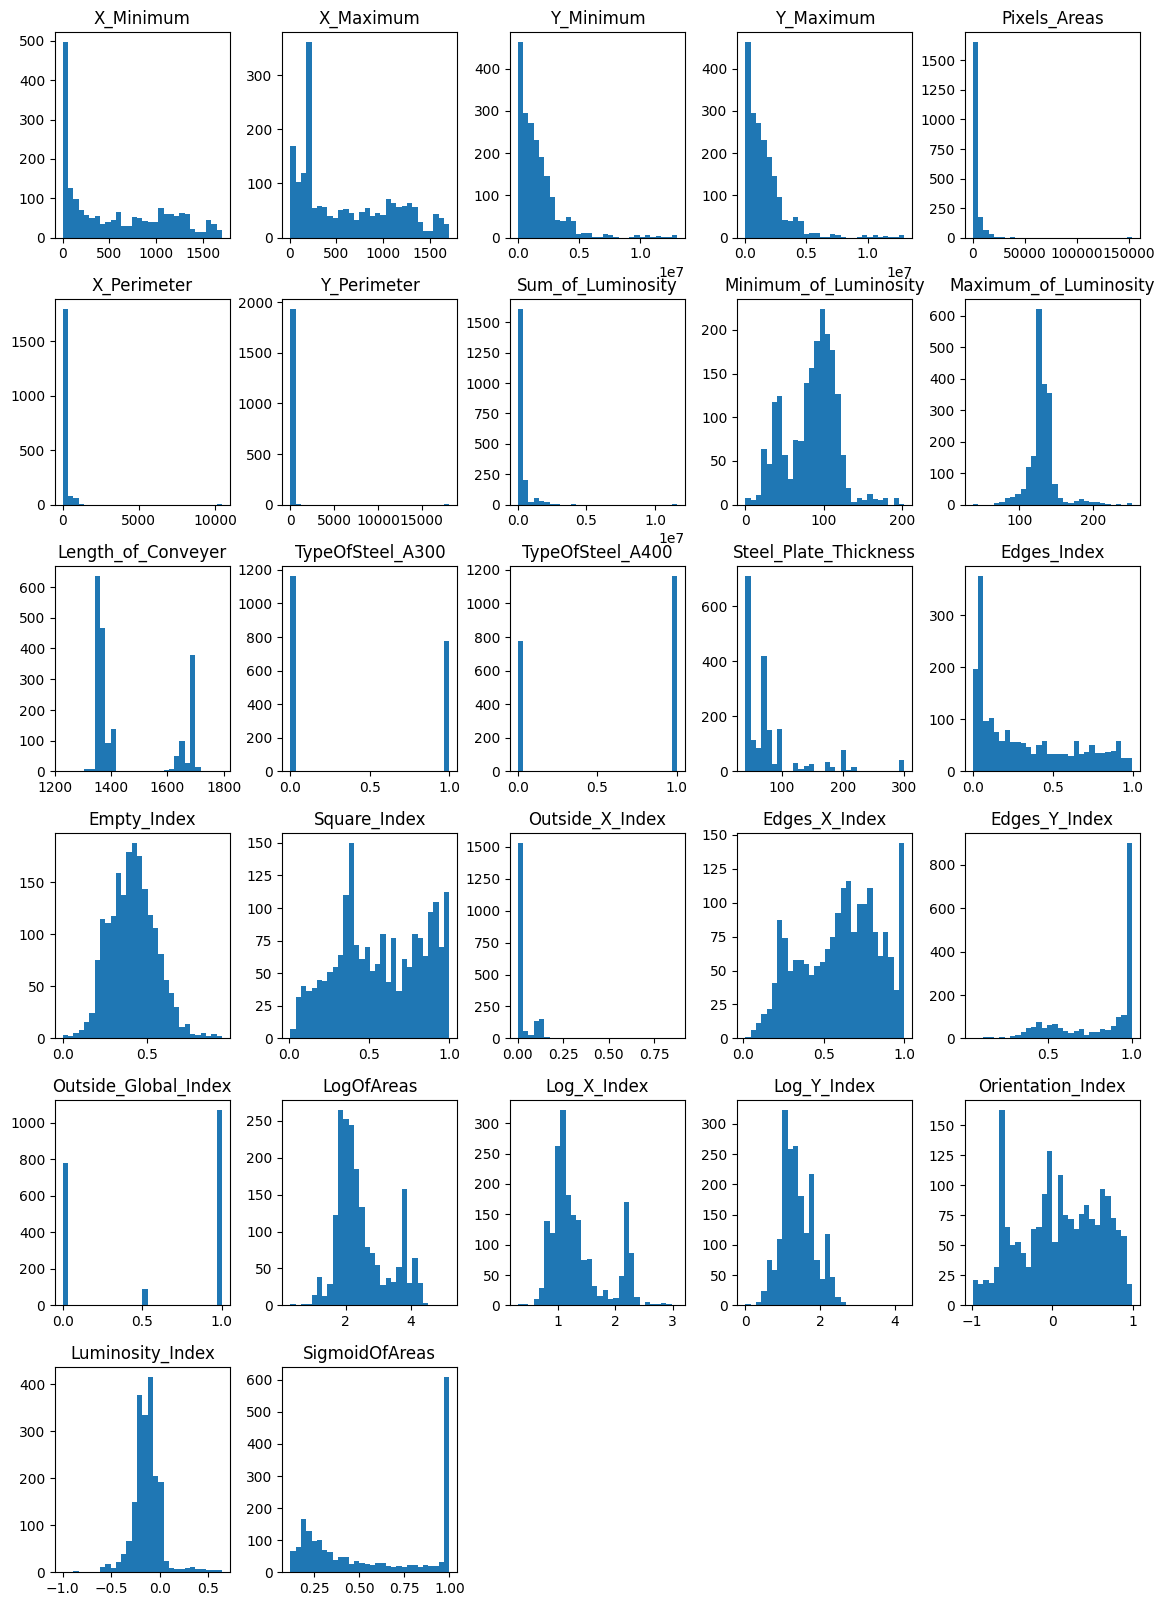

In [5]:
# 데이터 분포 확인
df3.iloc[:,:27].hist(bins=30, figsize=(14,20), grid=False)
plt.show()

# Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity 아웃라이어 존재

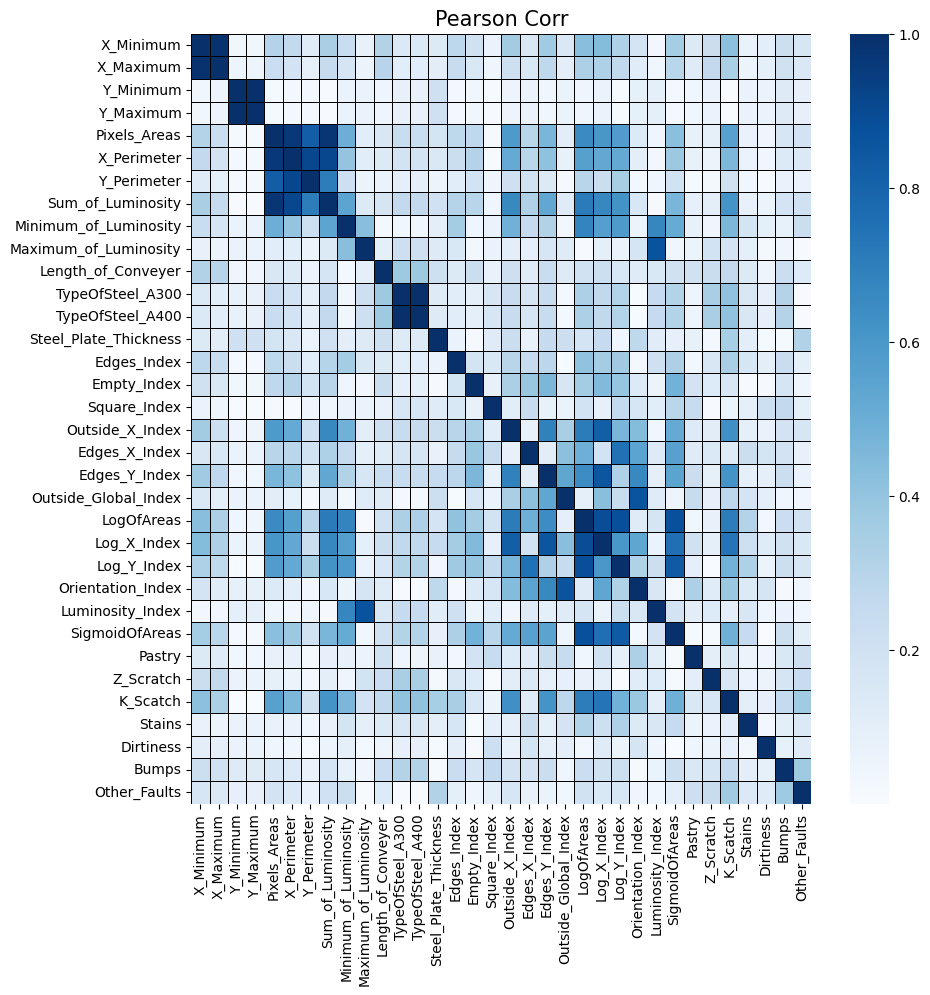

In [6]:
# 상관계수 확인
plt.figure(figsize=(10,10))
sns.heatmap(df3.corr().abs(), cmap='Blues', linewidths=0.4, linecolor='black')
plt.title('Pearson Corr', fontsize=15)
plt.show()

In [7]:
# X, Y의 min max는 상관계수 1
# TypeOfSteel 300/400은 상관계수 1 => 같은 것을 말하고 있는 컬럼이므로 둘 중 1개를 드랍

df3['TypeOfSteel'] = df3['TypeOfSteel_A300']
df3 = df3.drop(['TypeOfSteel_A300', 'TypeOfSteel_A400'], axis=1)

In [8]:
# Outside_Global_Index 컬럼에 대해 원핫 인코딩 수행

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(df3[['Outside_Global_Index']])

df_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['Outside_Global_Index']))

# 원핫 인코딩 결과를 원래 데이터프레임에 합칠 수도 있습니다.
df_encoded = pd.concat([df3, df_encoded], axis=1)
df_encoded = df_encoded.drop('Outside_Global_Index', axis=1)

df_encoded

/Users/nayeon/miniforge3/envs/project1/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,TypeOfSteel,Outside_Global_Index_0.0,Outside_Global_Index_0.5,Outside_Global_Index_1.0
0,42,50,270900,270944,267,17,44,24220,76,108,...,0,0,0,0,0,0,1,0.0,0.0,1.0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0,0,0,0,0,0,1,0.0,0.0,1.0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0,0,0,0,0,0,1,0.0,0.0,1.0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0,0,0,0,0,0,0,0.0,0.0,1.0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0,0,0,0,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,0,0,0,0,0,1,0,1.0,0.0,0.0
1937,144,175,340581,340598,287,44,24,34599,112,133,...,0,0,0,0,0,1,0,1.0,0.0,0.0
1938,145,174,386779,386794,292,40,22,37572,120,140,...,0,0,0,0,0,1,0,1.0,0.0,0.0
1939,137,170,422497,422528,419,97,47,52715,117,140,...,0,0,0,0,0,1,0,1.0,0.0,0.0


In [9]:
df_encoded.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index',
       'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'TypeOfSteel',
       'Outside_Global_Index_0.0', 'Outside_Global_Index_0.5',
       'Outside_Global_Index_1.0'],
      dtype='object')

/var/folders/1_/fd7qw8r91rs1ngprh0_lh2hm0000gn/T/ipykernel_72931/959264955.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['label'] = np.argmax(target.values, axis=1)


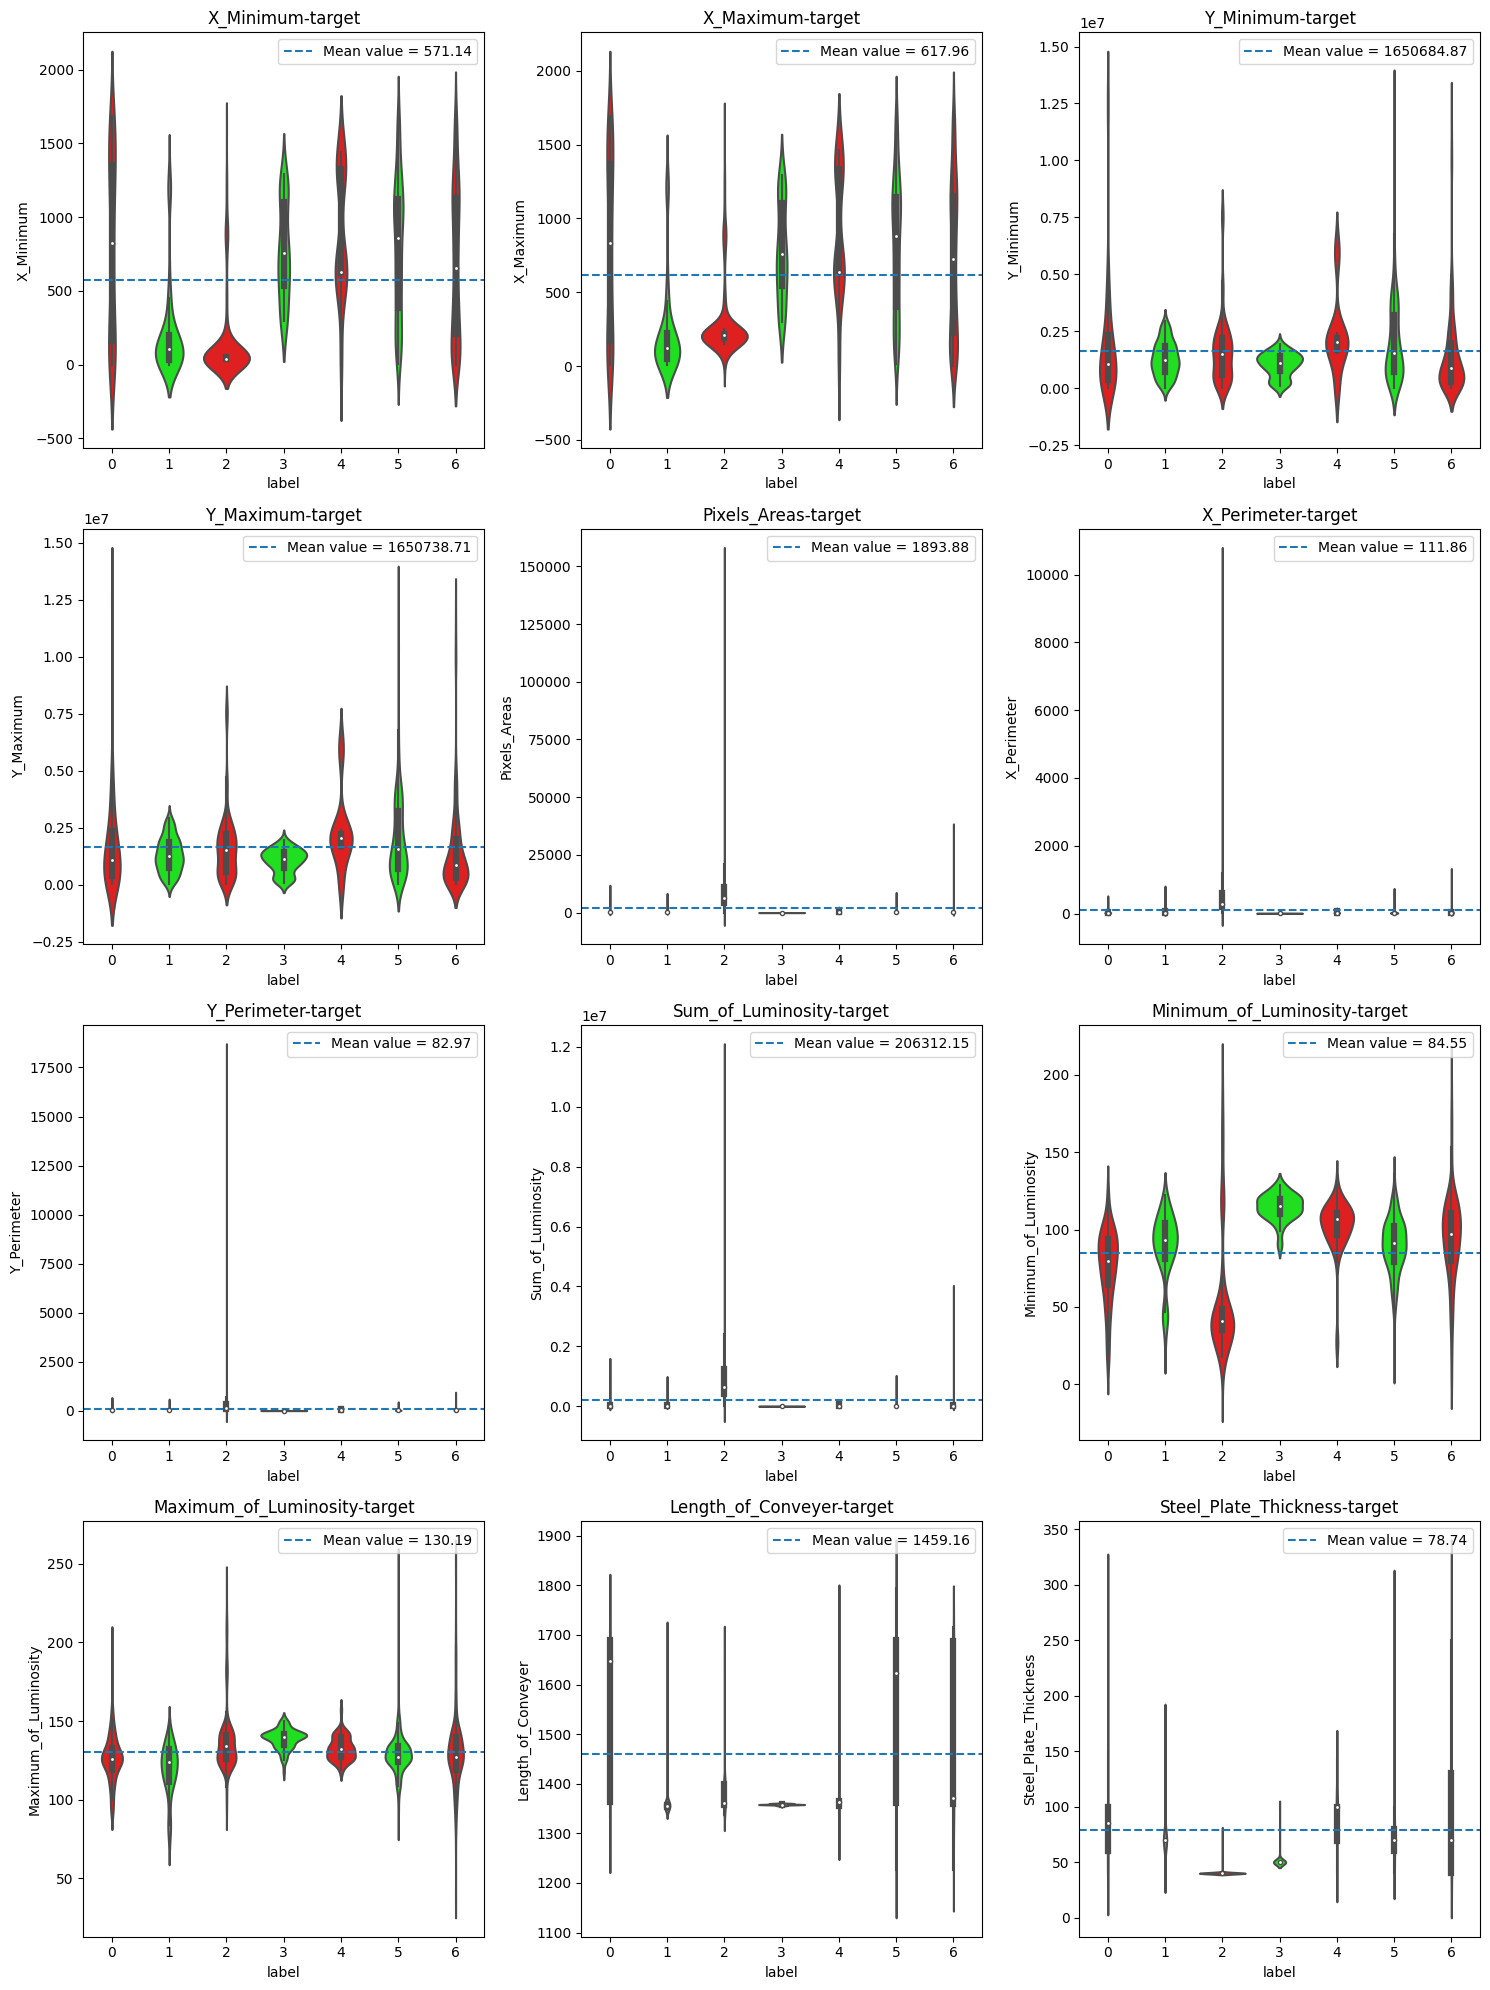

In [19]:
# 바이올린 플롯1


target_list = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

target = df_encoded[target_list]

target['label'] = np.argmax(target.values, axis=1)

df_encoded['label'] = target['label']

features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'Steel_Plate_Thickness']

plt.figure(figsize=(15,20))
j = 0
for i in features:
       plt.subplot(4,3,j+1)
       sns.violinplot(x=df_encoded['label'], y=df_encoded[i], palette=["red","lime"])
       plt.title(f'{i}-target')
       plt.axhline(df_encoded[i].mean(), linestyle="dashed", label="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

plt.tight_layout()
plt.show()


/var/folders/1_/fd7qw8r91rs1ngprh0_lh2hm0000gn/T/ipykernel_72931/3056701688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['label'] = np.argmax(target.values, axis=1)


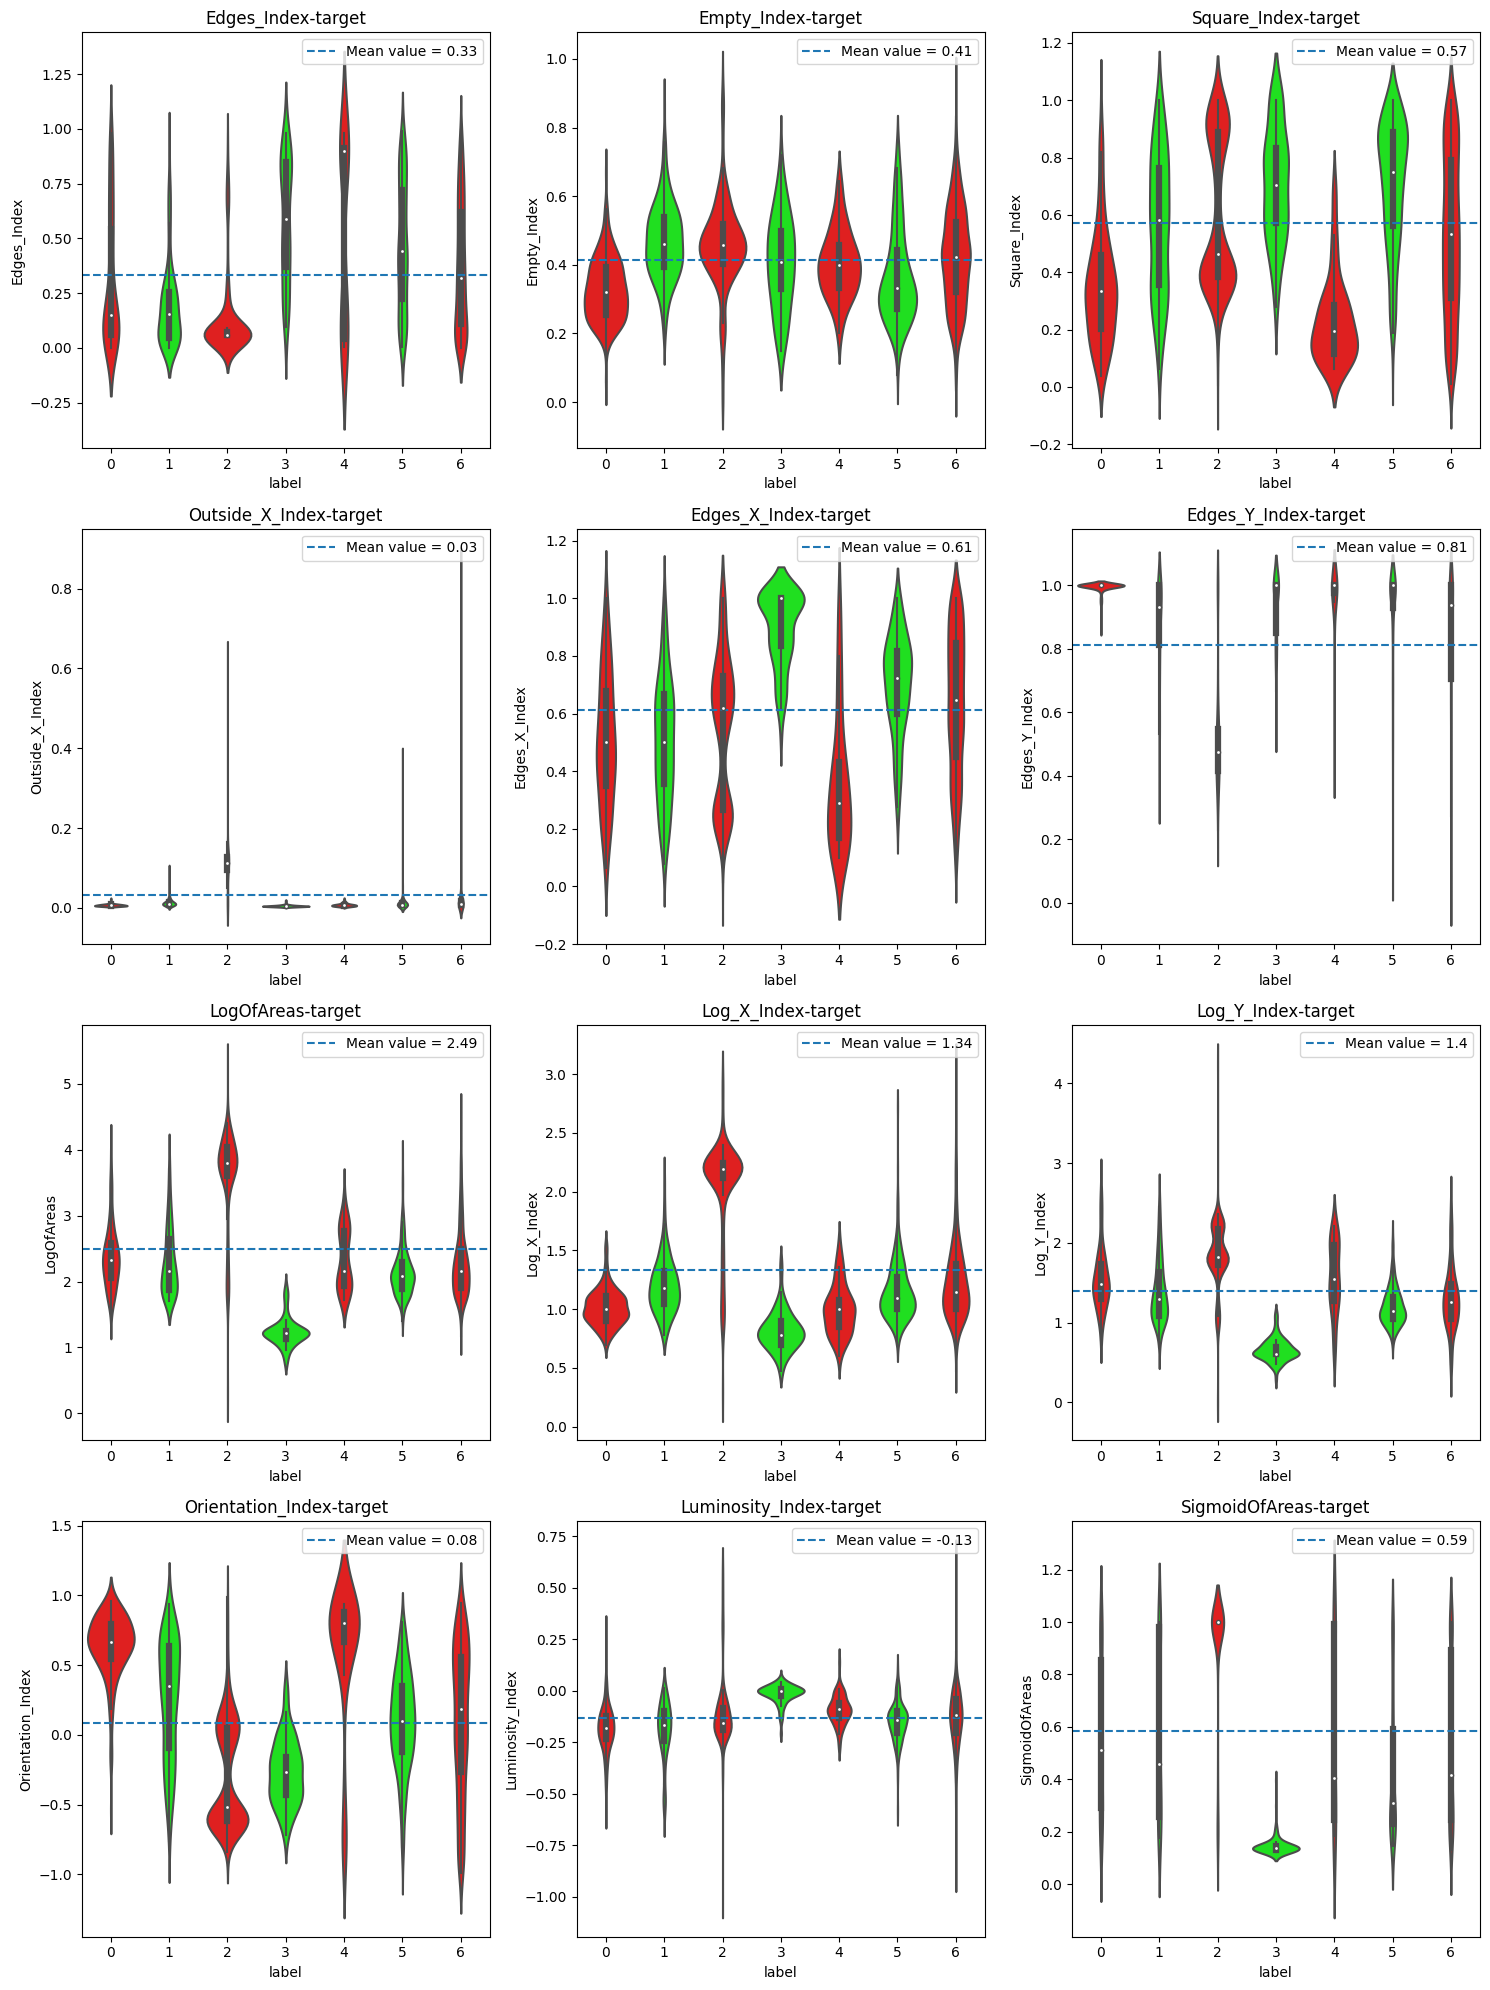

In [20]:
# 바이올린 플롯2

target_list = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

target = df_encoded[target_list]

target['label'] = np.argmax(target.values, axis=1)

df_encoded['label'] = target['label']

features = ['Edges_Index', 'Empty_Index', 'Square_Index',
       'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']

plt.figure(figsize=(15,20))
j = 0
for i in features:
       plt.subplot(4,3,j+1)
       sns.violinplot(x=df_encoded['label'], y=df_encoded[i], palette=["red","lime"])
       plt.title(f'{i}-target')
       plt.axhline(df_encoded[i].mean(), linestyle="dashed", label="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

plt.tight_layout()
plt.show()

/var/folders/1_/fd7qw8r91rs1ngprh0_lh2hm0000gn/T/ipykernel_72931/4289907905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['label'] = np.argmax(target.values, axis=1)


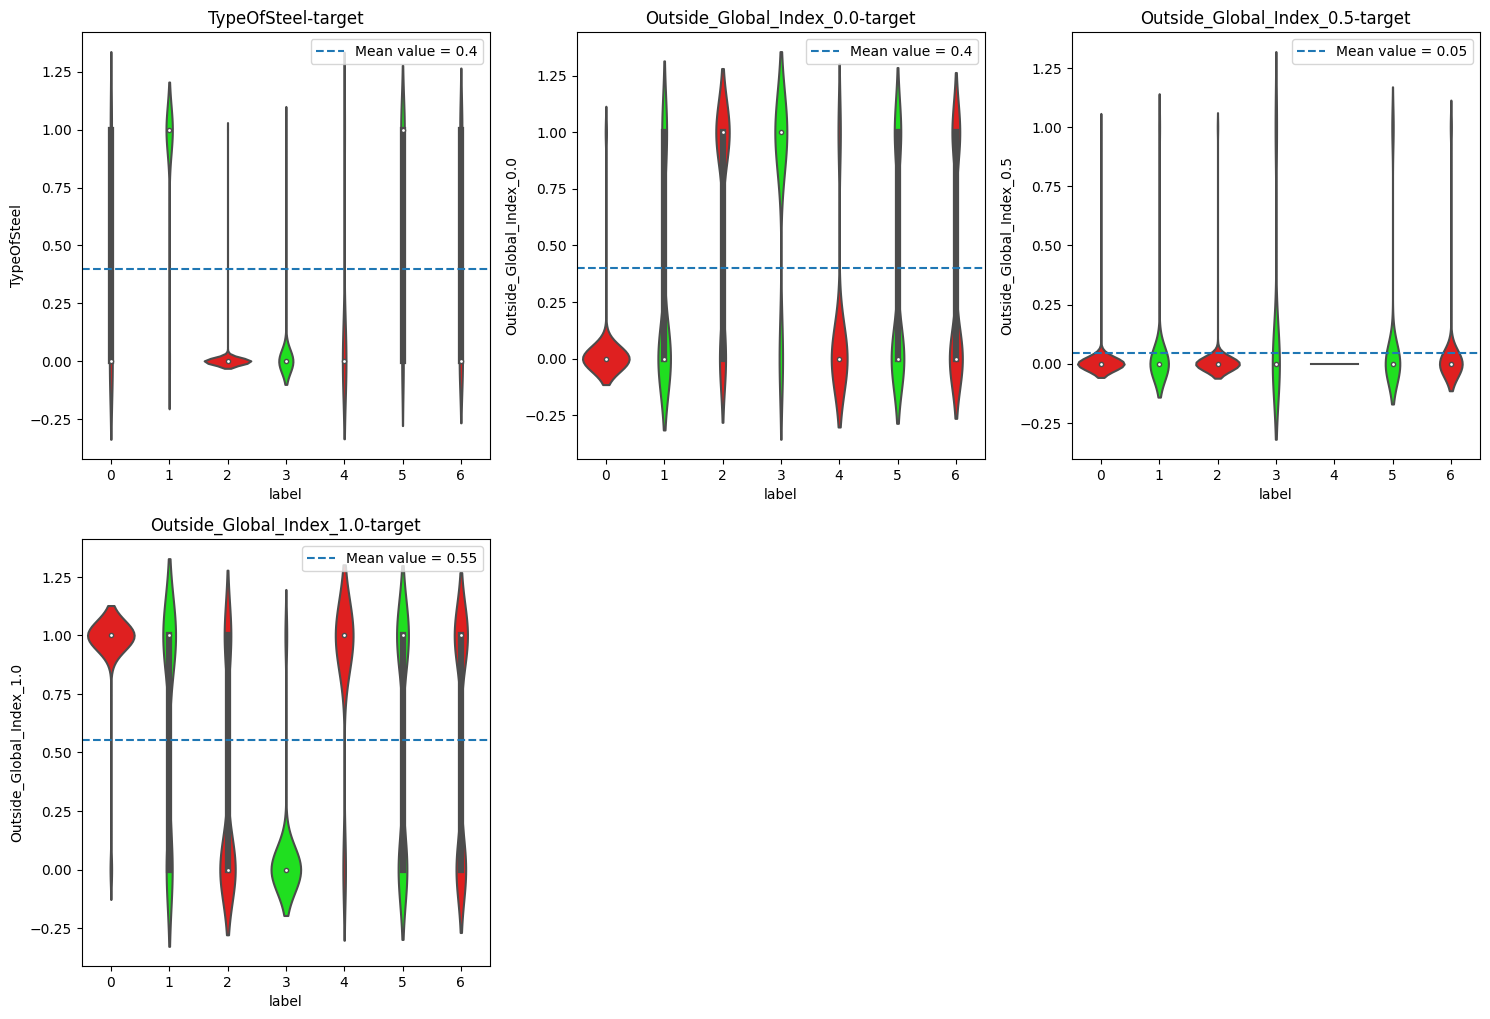

In [21]:
# 바이올린 플롯3

target_list = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

target = df_encoded[target_list]

target['label'] = np.argmax(target.values, axis=1)

df_encoded['label'] = target['label']

features = ['TypeOfSteel',
       'Outside_Global_Index_0.0', 'Outside_Global_Index_0.5',
       'Outside_Global_Index_1.0']

plt.figure(figsize=(15,20))
j = 0
for i in features:
       plt.subplot(4,3,j+1)
       sns.violinplot(x=df_encoded['label'], y=df_encoded[i], palette=["red","lime"])
       plt.title(f'{i}-target')
       plt.axhline(df_encoded[i].mean(), linestyle="dashed", label="Mean value = " + str(round(df_encoded[i].mean(), 2)))
       plt.legend(loc="best")
       j = j + 1

plt.tight_layout()
plt.show()

In [ ]:
# 바이올린 플롯 그릴 때 사용한 레이블 삭제

df_encoded = df_encoded.drop('label', axis=1)

In [ ]:
# 이상치를 클리핑으로 처리
for Feature in df_encoded.columns:
    # IQR을 이용하여 이상치 확인 및 처리
    Q1 = df_encoded[Feature].quantile(0.25)
    Q3 = df_encoded[Feature].quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 확인
    outliers = df_encoded[(df_encoded[Feature] < Q1 - 1.5 * IQR) | (df_encoded[Feature] > Q3 + 1.5 * IQR)]
    print("이상치 확인:")
    print(outliers)

    # 이상치 처리 (이상치를 하한값 혹은 상한값으로 대체)
    line_down = df_encoded[Feature].quantile(0.25) - IQR * 1.5
    line_up = df_encoded[Feature].quantile(0.75) + IQR * 1.5
    df_encoded[Feature] = df_encoded[Feature].clip(line_down, line_up)

print("이상치 처리 후:")
print(df_encoded)

이상치 확인:
Empty DataFrame
Columns: [X_Minimum, X_Maximum, Y_Minimum, Y_Maximum, Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity, Minimum_of_Luminosity, Maximum_of_Luminosity, Length_of_Conveyer, TypeOfSteel_A300, TypeOfSteel_A400, Steel_Plate_Thickness, Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index, LogOfAreas, Log_X_Index, Log_Y_Index, Orientation_Index, Luminosity_Index, SigmoidOfAreas, Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults, Outside_Global_Index_0.0, Outside_Global_Index_0.5, Outside_Global_Index_1.0]
Index: []

[0 rows x 37 columns]
이상치 확인:
Empty DataFrame
Columns: [X_Minimum, X_Maximum, Y_Minimum, Y_Maximum, Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity, Minimum_of_Luminosity, Maximum_of_Luminosity, Length_of_Conveyer, TypeOfSteel_A300, TypeOfSteel_A400, Steel_Plate_Thickness, Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_G

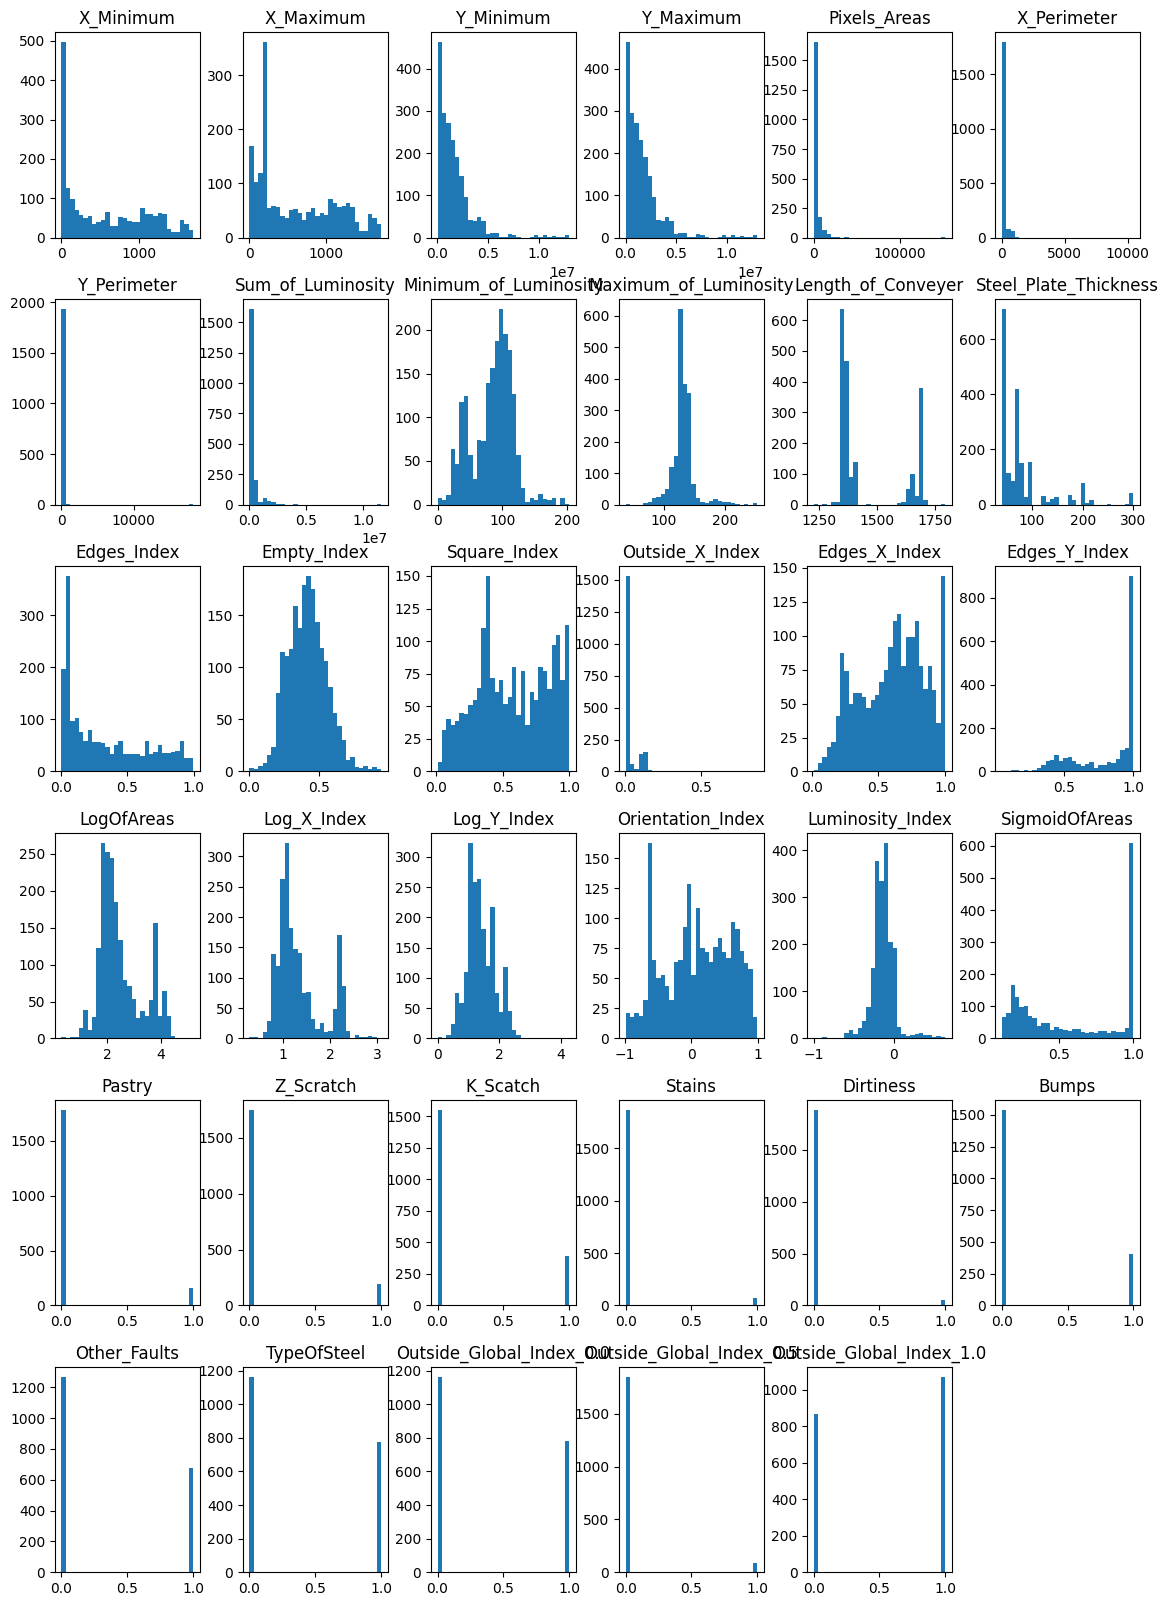

In [ ]:
# 클리핑후 데이터 분포 확인
df_encoded.hist(bins=30, figsize=(14,20), grid=False)
plt.show()

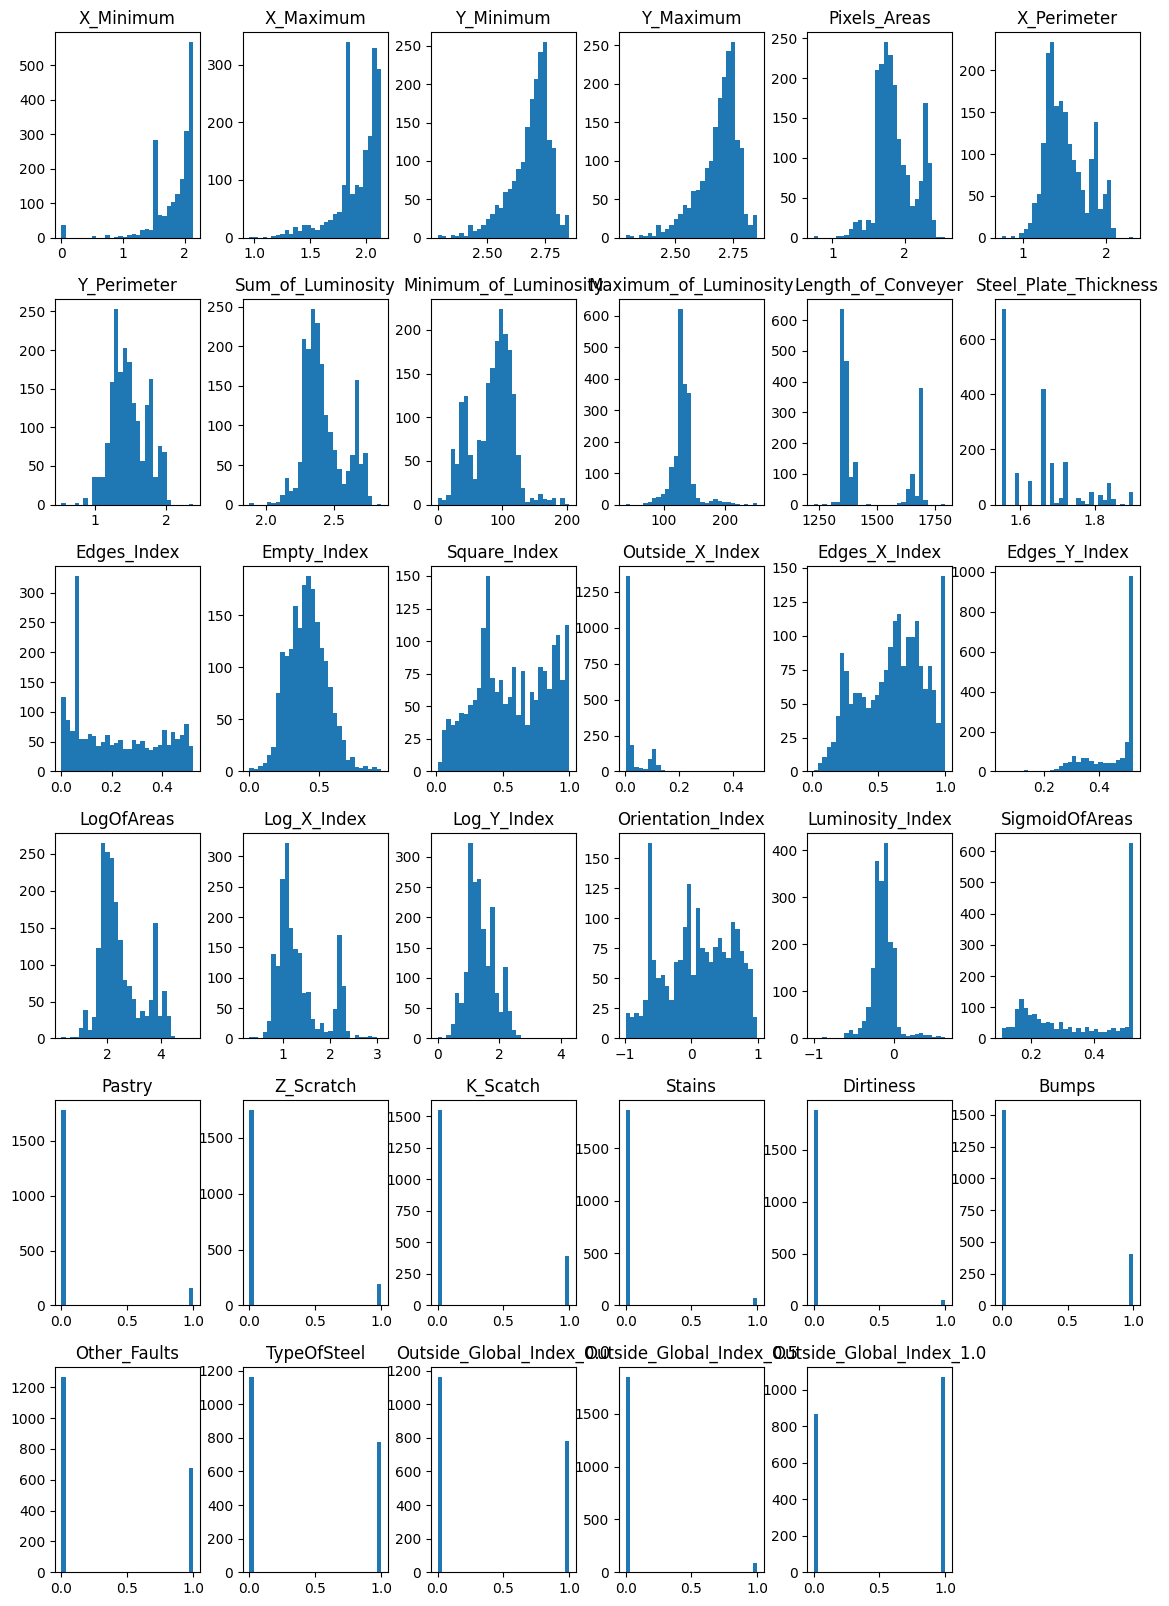

In [ ]:
# skewed된 데이터가 있는 컬럼에 대해 로그변환
# 로그변환 적용할 컬럼
features = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',  'Steel_Plate_Thickness', 'Edges_Index',    'Outside_X_Index',  'Edges_Y_Index', 'SigmoidOfAreas']
df3_lt = df_encoded

for i in features:
    df3_lt[i] = np.log1p(df3_lt[i])

# 로그변환 후 데이터 분포 확인
df3_lt.hist(bins=30, figsize=(14,20), grid=False)
plt.show()

In [ ]:
# 표준화

columns = df3_lt.columns
scaler = StandardScaler()
df3_scaled = scaler.fit_transform(df3_lt)
df3_scaled = pd.DataFrame(df3_scaled, columns=columns)

X = df3_scaled.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'], axis=1)

y_with_other = df3_scaled[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']]

y_without_other = df3_scaled[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps']]

# Splitting the data into train and test sets
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X, y_with_other, test_size=0.2, random_state=42)
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X, y_without_other, test_size=0.2, random_state=42)